A generative model-based approach that estimates a non-linear state transition function from pixels by using a locally-linear approximation.
<br><br><br>
Reference:

[Embed to Control: A Locally Linear Latent Dynamics Model for Control from Raw Images](https://arxiv.org/abs/1506.07365)

In [ ]:
import random
import sympy as sym
import numpy as np
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt
from google.colab import drive
def custom_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/3.1.1/latest.js?config=TeX-AMS_HTML"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
sym.init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    th.manual_seed(seed)

    # Torch gpu
    if th.cuda.is_available():
        th.cuda.manual_seed(seed)
        th.cuda.manual_seed_all(seed)
set_seed(42)

drive.mount('/content/drive')
device = th.device("cuda" if th.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def anim_frames(frames):
  """
  Animation function to play an animation from an image tensor of shape
  (num_frames, H, W, C).
  """
  from IPython.display import HTML
  import matplotlib.animation as animation

  fig, ax = plt.subplots()
  ax.axis('off')
  im = ax.imshow(frames[0].numpy())

  def update(frame):
      im.set_array(frame.numpy())
      return [im]

  # Animate and display
  ani = animation.FuncAnimation(fig, update, frames=frames, interval=50)
  plt.close(fig)
  display(HTML(ani.to_jshtml()))

In [ ]:
n_samples = 100
t0 = 0.0
tf = 0.5
file_path_drive = fr"/content/drive/My Drive/MS Thesis/Data/particle_in_grav_img_{n_samples}_{t0}_{tf}.pt"
dataset = th.load(file_path_drive)
print(dataset.shape)
dataset.to(device)
anim_frames(dataset[-1])

torch.Size([100, 50, 64, 64, 3])


Encoder and Decoder

In [ ]:
class ConvEncoder(nn.Module):
  def __init__(self, batch_size, latent_size, conv_params):
    super().__init__()

    self.latent_size = latent_size

    # CNN parameters
    k = conv_params['kernel_size']
    s = conv_params['stride']
    p = conv_params['pad']
    self.in_image_shape = (conv_params['C'], conv_params['H'], conv_params['W'])

    # Define encoder part of autoencoder
    self.encoder_cnn = nn.Sequential(
        nn.Conv2d(self.in_image_shape[0], 32, kernel_size=k, stride=s, padding=p),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=k, stride=s, padding=p),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=k, stride=s, padding=p),
        nn.ReLU(),
    )

    with th.no_grad():
        x = th.zeros(batch_size, self.in_image_shape[0], self.in_image_shape[1], self.in_image_shape[2])
        enc_out = self.encoder_cnn(x)
        self.out_dim_flat = enc_out.view(enc_out.size(0), -1).shape[1] # Keep batch dim, determine number of elements
        self.out_shape = enc_out.shape

  def forward(self, x):
    encoded = self.encoder_cnn(x)
    return encoded

class ConvDecoder(nn.Module):
  def __init__(self, latent_size, conv_params, enc_out_dim, enc_out_shape):
    super().__init__()

    self.latent_size = latent_size

    # CNN parameters
    k = conv_params['kernel_size']
    s = conv_params['stride']
    p = conv_params['pad']
    self.out_image_shape = (conv_params['C'], conv_params['H'], conv_params['W'])
    self.enc_out_shape = enc_out_shape

    self.fc_decode = nn.Linear(self.latent_size, enc_out_dim)

    # Define decoder part of autoencoder
    self.decoder_cnn = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=k, stride=s, padding=p),  # TODO: Generalize input
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=k, stride=s, padding=p),
        nn.ReLU(),
        nn.ConvTranspose2d(32, self.out_image_shape[0], kernel_size=k, stride=s, padding=p),
        nn.Sigmoid(), # Keep between 0 and 1
    )

  def forward(self, z):
    to_decode = self.fc_decode(z)
    C, H, W = self.enc_out_shape[1:]
    to_decode = to_decode.view(z.shape[0], C, H, W)
    decoded = self.decoder_cnn(to_decode)
    return decoded

In [ ]:
class E2C(nn.Module):
  def __init__(self, batch_size, latent_size, control_size, conv_params):
    super().__init__()

    # Set number of hidden units
    self.latent_size = latent_size
    self.control_size = control_size

    # Encoder and decoder
    self.encoder = ConvEncoder(batch_size, self.latent_size, conv_params)

    self.mu = nn.Linear(self.encoder.out_dim_flat, self.latent_size)
    self.log_var = nn.Linear(self.encoder.out_dim_flat, self.latent_size)

    self.decoder = ConvDecoder(self.latent_size, conv_params, self.encoder.out_dim_flat, self.encoder.out_shape)

    # Locally linear transition model
    self.v = nn.Linear(self.latent_size, self.latent_size)  # A jacobian
    self.r = nn.Linear(self.latent_size, self.latent_size)
    self.B = nn.Linear(self.latent_size, self.latent_size*self.control_size)
    self.o = nn.Linear(self.latent_size, self.latent_size)
    self.H = nn.Linear(self.latent_size, self.latent_size)

  def reparameterize(self, mu, log_var):
    # Get standard deviation from log variance
    std = th.exp(0.5 * log_var)

    # Generate random noise epsilon of same shape std
    eps = th.randn_like(std)

    # Return reparameterized sample
    return mu + eps * std

  def transition(self, z, mu, log_var, u):
    # Get Jacobians and linear model parameters
    v = self.v(z).unsqueeze(-1)                                                    #   [batch, z, 1]
    r = self.r(z).unsqueeze(-1)                                                    #   [batch, z, 1]
    A = th.eye(self.latent_size).to(device) + th.bmm(v, r.transpose(1, 2))         #   [batch, z, z]
    B = self.B(z).reshape((-1, self.latent_size, self.control_size))               #   [batch, z, u]
    o = self.o(z).unsqueeze(-1)                                                    #   [batch, z, 1]
    H = th.diag_embed(self.H(z))                                                   #   [batch, z, z]

    # Use linear model and reparam to create posterior distribution
    mu_next = th.bmm(A, mu.unsqueeze(-1)) + th.bmm(B, u.unsqueeze(-1)) + o         #   [batch, z, 1]
    mu_next = mu_next.squeeze(-1)                                                  #   [batch, z]
    sigma = th.diag_embed(th.exp(log_var))                                         #   [batch, z, z]
    C = th.bmm(A, th.bmm(sigma, A.transpose(1, 2))) + H                            #   [batch, z, z]
    C = th.diagonal(C, dim1=-2, dim2=-1)                                           #   [batch, z]
    z_next = self.reparameterize(mu_next, C)                                       #   [batch, z]

    return mu_next, C, z_next

  def forward(self, x, u):
    # Encode current state
    encoded = self.encoder(x)
    flattened = encoded.view(encoded.size(0), -1)

    # Get latent variable
    mu = self.mu(flattened)
    log_var = self.log_var(flattened)
    z = self.reparameterize(mu, log_var)

    # Transition model
    z_next, mu_next, log_var_next = self.transition(z, mu, log_var, u)

    # Get reconstruction and prediction
    x_recon = self.decoder(z)
    x_next = self.decoder(z_next)

    train_return = {
        'encoded': encoded,
        'x_recon': x_recon,
        'mu': mu,
        'log_var': log_var,
        'x_next': x_next,
        'mu_next': mu_next,
        'log_var_next': log_var_next
    }

    return train_return


E2C Dataset Class to sample (x, x_next, u) triplets

In [ ]:
class E2CDataset(th.utils.data.Dataset):
  def __init__(self, X, X_next, U):
    self.X = X
    self.X_next = X_next
    self.U = U

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.X_next[idx], self.U[idx]

E2C loss class

In [ ]:
class E2CLoss(nn.Module):
  def __init__(self, num_epochs, loss_params):
    super().__init__()
    self.num_epochs = num_epochs
    self.beta = loss_params['beta']
    self.anneal_mode = loss_params['kld_anneal_mode']

  def kld_anneal(self, epoch):
    return self.beta

  def forward(self, train_return, epoch):
    test = th.tensor(0.0, device=device, requires_grad=True)
    return test, test, test

Training function

In [ ]:
def train_vae(dataset, conv_params, loss_params, latent_size=8, learning_rate=1e-3, num_epochs=10, batch_size=32):
  # Temporary, no controls
  control_size = 2  # x and y velocities

  # Create autoencoder model and optimizer
  model = E2C(batch_size, latent_size, control_size, conv_params)
  model.to(device)
  optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)

  # Reformat dataset to create (x, x_next, u) triplets by flattening sequence dimension
  X = dataset[:, :-1]   # Shape: [batch, seq_len - 1, H, W, C]
  X_next = dataset[:, 1:]
  X = X.reshape(-1, X.shape[2], X.shape[3], X.shape[4]).permute(0, 3, 1, 2) # Shape: [batch, C, H, W]
  X_next = X_next.reshape(-1, X_next.shape[2], X_next.shape[3], X_next.shape[4]).permute(0, 3, 1, 2)
  U = th.zeros((X.shape[0], control_size))

  # Create Dataset and DataLoader to handle batching of training data
  e2c_dataset = E2CDataset(X, X_next, U)
  train_loader = th.utils.data.DataLoader(
      e2c_dataset, batch_size=batch_size, shuffle=True
  )

  # Create loss criterion
  criterion = E2CLoss(num_epochs, loss_params)

  # Training loop
  recon_loss_hist = []
  kld_loss_hist = []
  for epoch in range(num_epochs):
    total_loss = 0.0

    for x, x_next, u in train_loader:
      # Send training data to GPU
      x, x_next, u = x.to(device), x_next.to(device), u.to(device)

      # Forward pass
      train_return = model(x, u)

      # Compute loss and backprop
      loss, recon_loss, kld_loss = criterion(train_return, epoch)
      recon_loss_hist.append(recon_loss.detach().cpu().item())
      kld_loss_hist.append(kld_loss.detach().cpu().item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item() * x.size(0)   # Aggregate total epoch loss

    # Average loss for the epoch
    epoch_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}: loss={epoch_loss:.4f}")

    # Plot loss during training
    plt.figure(figsize=(6,4))
    plt.plot(recon_loss_hist, label="Reconstruction Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Reconstruction Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(kld_loss_hist, label="KLD", color='orange')
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("KLD Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

  return model

Epoch 1/10: loss=0.0000


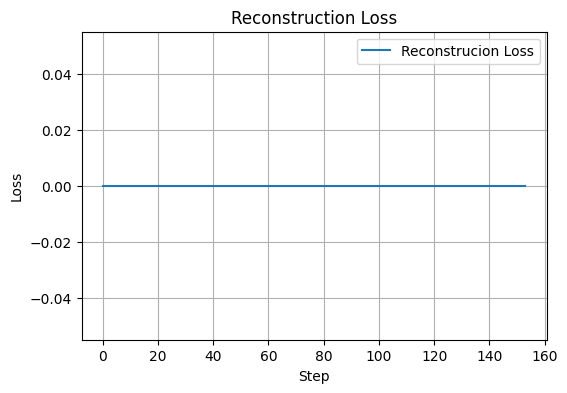

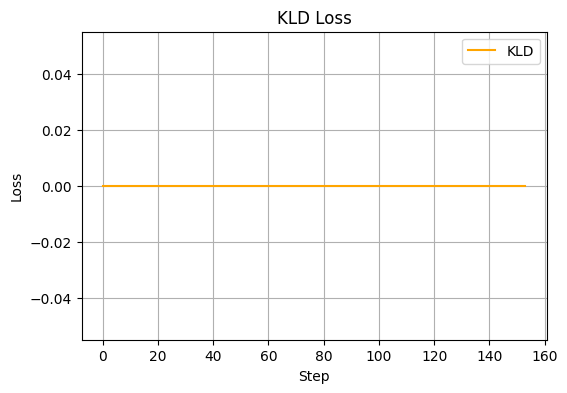

Epoch 2/10: loss=0.0000


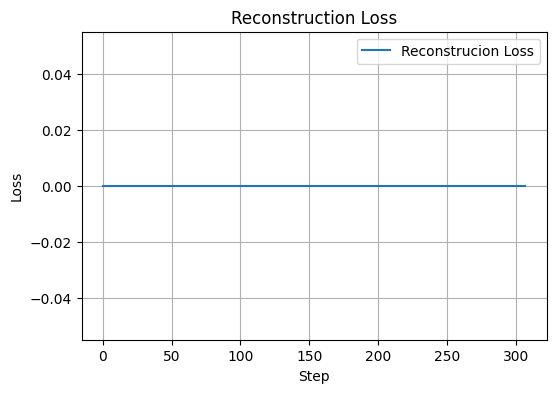

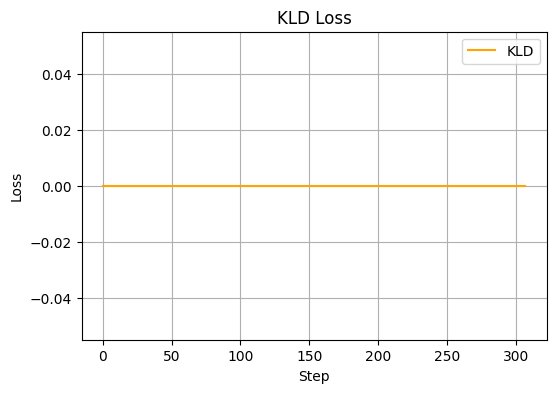

Epoch 3/10: loss=0.0000


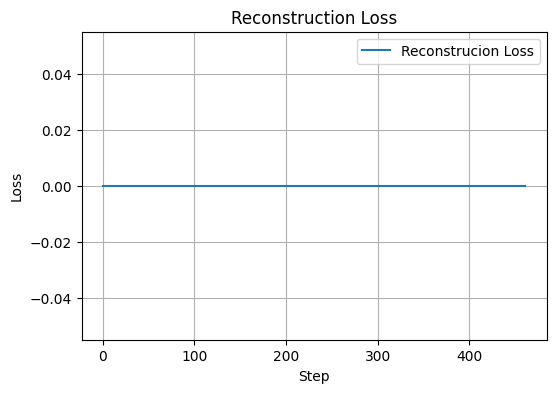

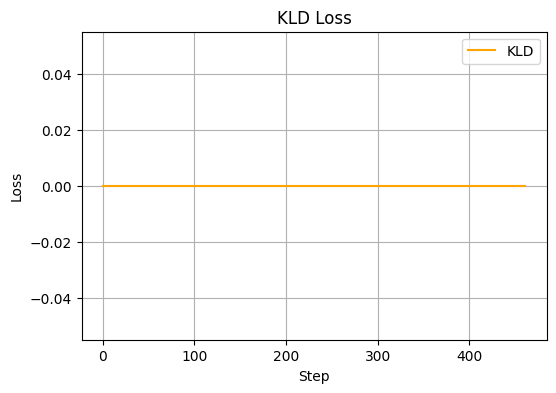

Epoch 4/10: loss=0.0000


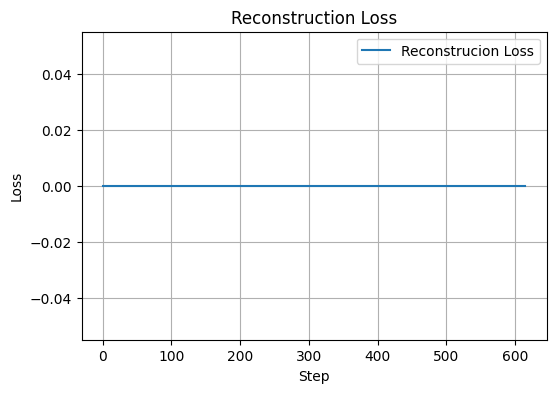

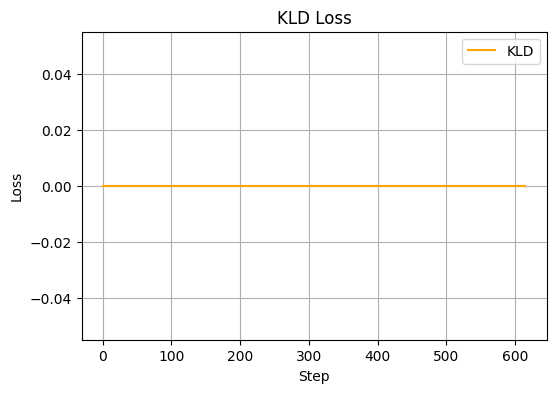

Epoch 5/10: loss=0.0000


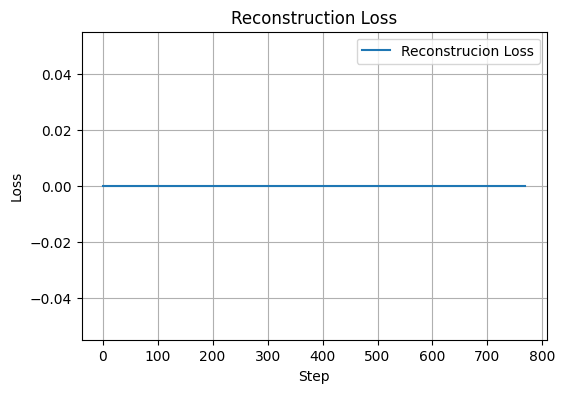

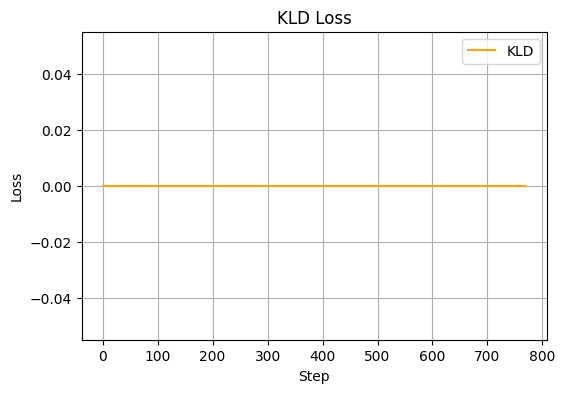

Epoch 6/10: loss=0.0000


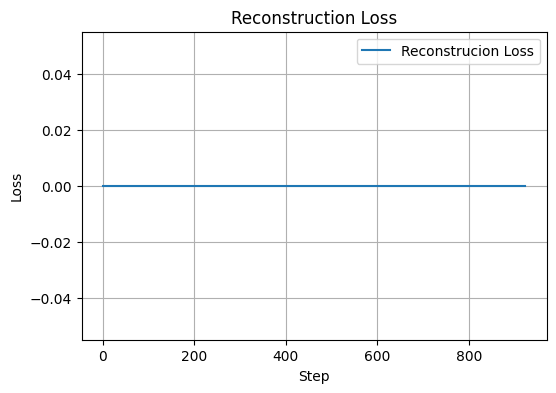

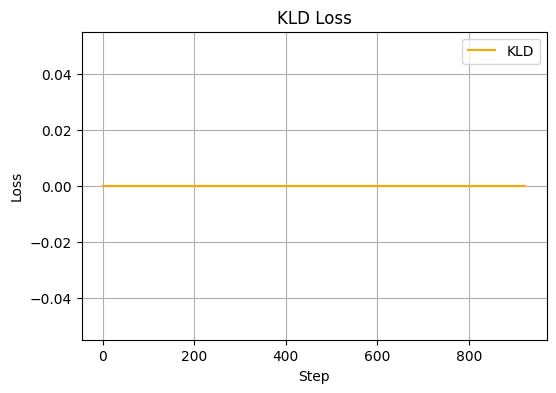

Epoch 7/10: loss=0.0000


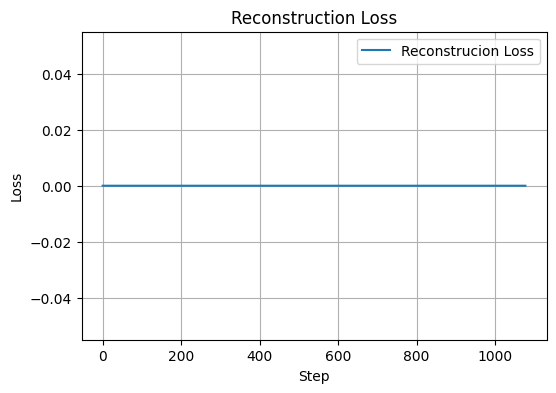

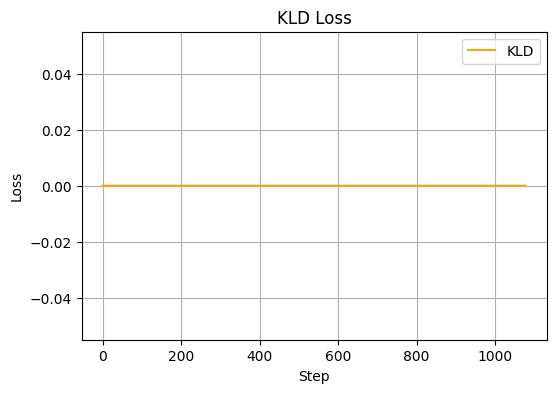

Epoch 8/10: loss=0.0000


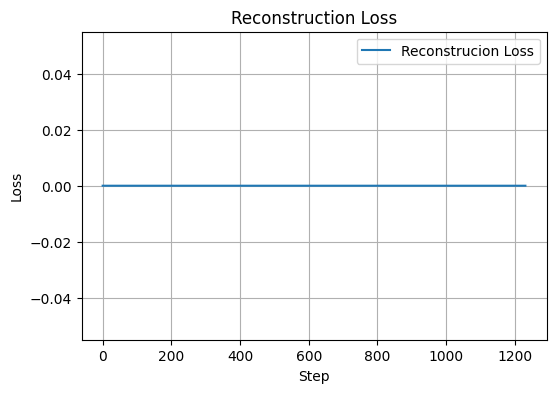

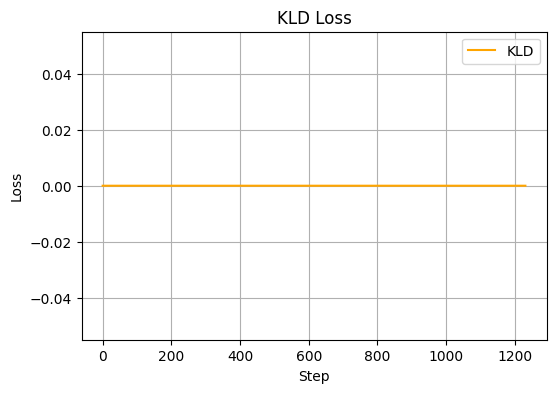

Epoch 9/10: loss=0.0000


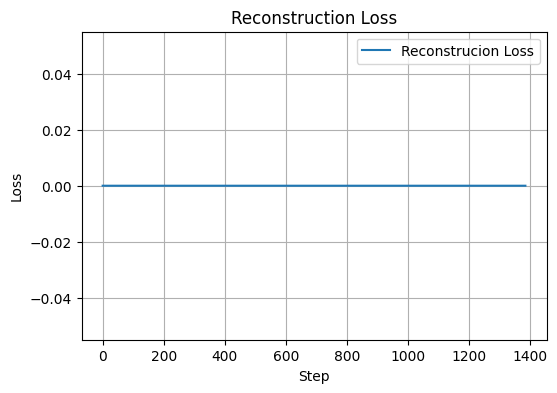

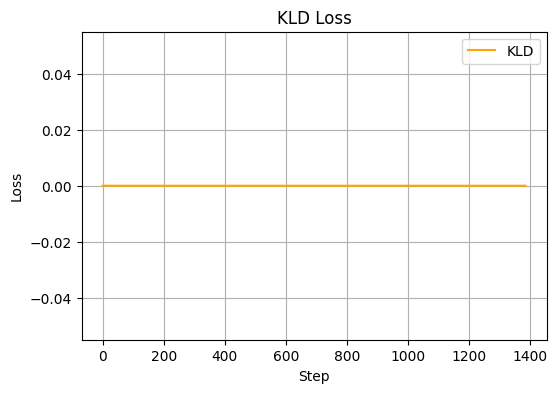

Epoch 10/10: loss=0.0000


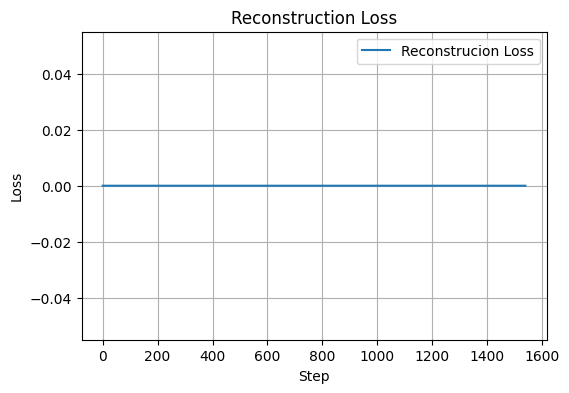

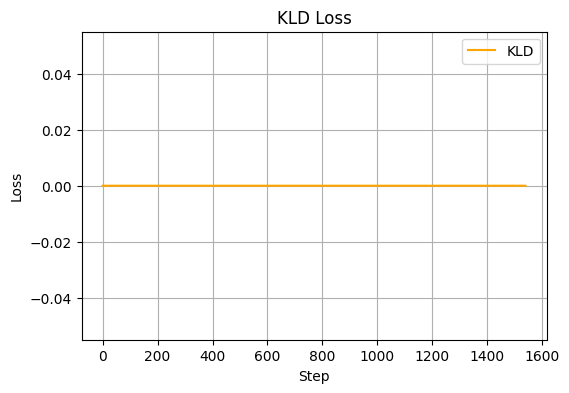

In [ ]:
#
# --- Train Model ---
#
conv_params = {
    'kernel_size': 4,
    'stride': 1,
    'pad': 0,
    'C': 3,
    'H': 64,
    'W': 64
}
loss_params = {
    'beta': 3e-5,
    'kld_anneal_mode': 'const'
}
model = train_vae(dataset, conv_params, loss_params, latent_size=8, learning_rate=1e-3, num_epochs=10, batch_size=32)